In [1]:
import glob
import copy
import re
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from decimal import Decimal

In [64]:
#Histogram (semi-major axis) plot function
def plot_a_hist(orbits, sim_num, timescale, Rcrit, ChemDist):
    fig, ax = plt.subplots(figsize=(16,8))
    binwidth = 1
    plt.hist(orbits, bins=np.arange(0., 2000. + binwidth, binwidth))
    plt.title("Final semi-major axes of comets, "+str(sim_num)+", t = "+timescale+" yrs, Rcrit = "+Rcrit+" "+ChemDist,fontsize=18)
    plt.xlabel("Orbit Distance (AU)",fontsize=16)
    plt.ylabel("Frequency",fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid()
    plt.savefig("Semi-major Axis Frequency, "+sim_num+", t = "+timescale+" yrs, Rcrit = "+Rcrit+" "+ChemDist+".png", bbox_inches='tight', format='png')

In [65]:
#Histogram (eccentricity) plot function
def plot_e_hist(orbits, sim_num, timescale, Rcrit, ChemDist):
    fig, ax = plt.subplots(figsize=(16,8))
    binwidth = 0.01
    plt.hist(orbits, bins=np.arange(0, 1 + binwidth, binwidth))
    plt.title("Final eccentricities of comets, "+str(sim_num)+", t = "+timescale+" yrs, Rcrit = "+Rcrit+" "+ChemDist,fontsize=18)
    plt.xlabel("Eccentricity",fontsize=16)
    plt.ylabel("Frequency",fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid()
    plt.savefig("Eccentricity Frequency, "+sim_num+", t = "+timescale+" yrs, Rcrit = "+Rcrit+" "+ChemDist+".png", bbox_inches='tight', format='png')

In [68]:
#Plot final semi-major axis vs. eccentricity
def plot_a_e(df, df2, sim_num, timescale, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        labels = df["ChemDist"]
        groups = df.groupby("ChemDist")
        for name, group in groups:
            ax.plot(group.a, group.e, marker='o', linestyle='', ms=4, label=name)
        
        if plot_observed_comets == "on":
            groups2 = df2.groupby("Chem_obs")
            for name2, group2 in groups2:
                ax.plot(group2.a_obs, group2.e_obs, marker='*', linestyle='', ms=16, label=name2)
        else:
            pass

        ax.legend()
        #fg = sns.FacetGrid(data=df, hue="ChemDist", hue_order=["None","CO2","CO","Both"], size=7, aspect=2)
        #fg.map(plt.scatter, "a", "e", s=8).add_legend()
    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        labels = df["ChemDist"]
        groups = df.groupby("ChemDist")
        for name, group in groups:
            ax.plot(group.a, group.e, marker='o', linestyle='', ms=4, label=name)

        if plot_observed_comets == "on":
            groups2 = df2.groupby("Chem_obs")
            for name2, group2 in groups2:
                ax.plot(group2.a_obs, group2.e_obs, marker='*', linestyle='', ms=16, label=name2)
        else:
            pass

        ax.legend()
        #fg = sns.FacetGrid(data=df, hue="ChemDist", hue_order=["CO","CO2"], size=7, aspect=2)
        #fg.map(plt.scatter, "a", "e", s=8).add_legend()
    elif ("LinearChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = plt.scatter(df["a"], df["e"],
                     c=df["Chem_ratio"], s=4, cmap="viridis")
        
        if plot_observed_comets == "on":
            points2 = plt.scatter(df2["a_obs"], df2["e_obs"],
                         c=df2["Chem_ratio_obs"], s=256, cmap="viridis", marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df2, scatter=False, fit_reg=False,color=".1")
        else:
            pass
        
        rp = sns.regplot("a", "e", data=df, scatter=False, fit_reg=False,color=".1")
        cbar = plt.colorbar(points)
        cbar.ax.set_ylabel("CO/CO2 Ratio", rotation=270)

    if max(df["a"]) > 50.:
        plt.xlim([2000,40000])
    if max(df["e"]) > 1.:
        plt.ylim([0.5,1])
    plt.xlabel("Semi-major axis (AU)", fontsize=16)
    plt.ylabel("Eccentricity", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title("Semi-major Axis vs. Eccentricity, "+sim_num+", t = "+timescale+" yrs, Rcrit = "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    plt.savefig("Semi-major Axis vs. Eccentricity, "+sim_num+", t = "+timescale+" yrs, Rcrit = "+Rcrit+" "+ChemDist+".png", 
                bbox_inches="tight", format="png")

In [5]:
#Distance vs. time plot function
def plot_a_time(a_orbits_list, t_list, sim_num, Rcrit):
    colors_list = ["C0","C1","C2","C3"]
    planets_list = ["Jupiter","Saturn","Uranus","Neptune"]
    patches = []
    
    fig, ax = plt.subplots(figsize=(8,8)) 
    
    #Plot planets as thicker lines
    for m in range(4):
        plt.plot(t_list,list(map(list, zip(*a_orbits_list)))[m], linewidth=5)
        
    #Pick five random comets to plot
    for n in comet_index_shuffle: 
        plt.plot(t_list,list(map(list, zip(*a_orbits_list)))[n])
        axes = plt.gca()
        if max(list(map(list, zip(*a_orbits_list)))[n]) > 70. or min(list(map(list, zip(*a_orbits_list)))[n]) < 0.:
            axes.set_ylim([0,70])
            
    for l in range(len(colors_list)):
        patches.append(mpatches.Patch(color=colors_list[l], label=planets_list[l]))
        
    plt.legend(handles=patches, loc="best")
    plt.title("Semi-major axis vs Time, "+str(sim_num))
    plt.xlabel("Time (Years)")
    plt.ylabel("Semi-Major Axis (AU)")
    plt.grid()
                        
    return comet_index_shuffle

In [6]:
#Distance vs. time plot function
def plot_e_time(e_orbits_list, t_list, sim_num, Rcrit):
    colors_list = ["C0","C1","C2","C3"]
    planets_list = ["Jupiter","Saturn","Uranus","Neptune"]
    patches = []
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    #Plot planets as thicker lines
    for m in range(4):
        plt.plot(t_list,e_orbits_list, linewidth=5)
        
    for n in comet_index_shuffle: 
        plt.plot(t_list,list(map(list, zip(*e_orbits_list)))[n])
        axes = plt.gca()
        if max(list(map(list, zip(*e_orbits_list)))[n]) > 1.:
            axes.set_ylim([0,1.])
            
    for l in range(len(colors_list)):
        patches.append(mpatches.Patch(color=colors_list[l], label=planets_list[l]))
        
    plt.legend(handles=patches, loc="best")
    plt.title("Eccentricity vs Time, "+str(sim_num))
    plt.xlabel("Time (Years)")
    plt.ylabel("Eccentricity")
    plt.grid()

In [54]:
###### Data read-in
#sim = rebound.Simulation.from_file(sim_name+".bin")

folderpath = '4.5e9_1000_Rcrit6_NoOverlapChem_Tides'
n_comets = 10
plot_observed_comets = "off"

outputdata = []
for filename in glob.glob('./Cluster_Output/'+folderpath+'/UNMigrate*.csv'):
    print(filename)
    df = pd.read_csv(filename,skiprows=1,names=['1', '2', '3', '4', '5'])
    #df = df.drop(df.index[[0,1499]])
    df = df.dropna(axis=0,how="all")
    #print(df)
    outputdata.append(df)

ChemDist = re.search('Rcrit6_(.*)', folderpath)
ChemDist = ChemDist.group(1)
print(ChemDist)
Rcrit = re.search('_Rcrit(.*)_NoOverlapChem', folderpath)
Rcrit = Rcrit.group(1)
print(Rcrit)

#print(outputdata)

for filename in glob.glob('./Cluster_Output/'+folderpath+'/UNMigrate*.csv'):
    df = pd.read_csv(filename)
    t_list = list(df.columns.values)
    t_list[0] = t_list[0].replace("[","")
    t_list[-1] = t_list[-1].replace("]","")
    t_list = [float(i) for i in t_list]
    break

'''#Chem ratio read-in
chemratiodata = []
for filename in glob.glob('./Cluster_Output/'+folderpath+'*.csv'):
    print(filename)
    df2 = pd.read_csv(filename)
    outputdata.append(df2)'''

./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides1.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides10.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides11.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides12.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides13.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides14.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides15.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides16.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides17.csv
./Cluster_Output/4.5e9_1000_Rcrit6_NoOverlapChem_Tides/UNMigrate_NoOverlapChem_Rcrit6_Tides18.csv
./Cluster_Output/4.5e

"#Chem ratio read-in\nchemratiodata = []\nfor filename in glob.glob('./Cluster_Output/'+folderpath+'*.csv'):\n    print(filename)\n    df2 = pd.read_csv(filename)\n    outputdata.append(df2)"

In [55]:
#Get final orbital parameters and change data into workable format (also exclude planet parameters)
def label_chemdist(row):
    if row["CO"] + row["CO2"] > 1.:
        return "Both"
    if row["CO"] == 1:
        return "CO"
    if row["CO2"] == 1:
        return "CO2"
    return "None"

def data_clean_final_orbits(output):
    #output = output.dropna(axis=0,how="all")
    output["Object_number"] = pd.to_numeric(output.iloc[:,0])
    #output["Object_number"] = output.reset_index().index
    output["a"] = pd.to_numeric(output.iloc[:,1])
    output["e"] = pd.to_numeric(output.iloc[:,2])
    #output = output.drop(output[(output["a"] < 0.) & (output["a"] > 100.)].index, axis=0)
    if ("BinaryChem" in ChemDist) or ("NoOverlapChem" in ChemDist):
        output["CO"] = pd.to_numeric(output.iloc[:,3])
        output["CO2"] = pd.to_numeric(output.iloc[:,4])
        output["ChemDist"] = output.apply(lambda row:label_chemdist(row),axis=1)
        output = output.drop(output.columns[:-6], axis=1)
    elif ("LinearChem" in ChemDist):
        output["Chem_ratio"] = pd.to_numeric(output.iloc[:,3])
        output = output.drop(output.columns[:-4], axis=1)
    #Drop planet orbits and only take final orbits
    #print(output)
    #output = output.reset_index(drop=True)
    output = output.dropna(axis=1,how="all")
    output = output.drop(output.index[:-n_comets], axis=0)
    #print(output)
    return output

outputdata_clean = [data_clean_final_orbits(output) for output in outputdata]

#Combine final orbital params of all comets
orbits_conc = pd.concat(outputdata_clean)
#orbits_conc.to_csv('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv')
orbits_conc

,Object_number,a,e,CO,CO2,ChemDist
8376,4,-2.956712e-10,3.812356e+16,0.0,1.0,CO2
8377,5,4.531257e+03,9.925082e-01,1.0,0.0,CO
8378,6,-3.163714e-07,6.545832e+13,0.0,1.0,CO2
8379,7,-6.498158e-13,6.561372e+20,0.0,1.0,CO2
8380,8,-3.424155e-09,1.970992e+15,0.0,1.0,CO2
8381,9,8.510868e+01,6.233497e-01,0.0,1.0,CO2
8382,10,-2.760716e-09,2.646066e+16,0.0,1.0,CO2
8383,11,-2.391362e-11,2.119092e+18,0.0,1.0,CO2
8384,12,-2.904292e-09,3.785345e+15,0.0,1.0,CO2
8385,13,-4.087837e-08,6.196145e+14,1.0,0.0,CO


In [56]:
print("Number of comets with e < 1:",(orbits_conc['e'] < 1.).sum()/len(orbits_conc['e']))

Number of comets with e < 1: 0.2404040404040404


In [47]:
#Add in known comet volatile ratios from current research
Names_obs = ["1P/Halley","153P/Ikeya-Zhang","8P/Tuttle","64P/Swift-Gehrels","19P/Borrelly","103P/Hartley 2","144P/Kushida",
            "67P/Churyumov-Gerasimenko","73P/Schwassmann-Wachmann 3-C","157P/Tritton","22P/Kopff","81P/Wild 2","88P/Howell",
            "118P/Shoemaker-Levy 4","9P/Tempel 1","116P/Wild 4","C/1979 Y1 Bradfield","C/1989 X1 Austin",
            "C/1990 K1 Levy","C/1995 O1 Hale-Bopp","C/1996 B2 Hyakutake","C/1999 H1 Lee","C/1999 S4 (LINEAR)",
            "C/2000 WM1 LINEAR","C/2001 A2 LINEAR","C/2004 Q2 Machholz","C/2006 OF2 Broughton","C/2007 N3 Lulin",
            "C/2007 Q3 Siding Spring","C/2008 Q3 Garradd","C/2009 P1 Garradd"]
a_obs = [17.834,51.214,5.702,4.451,3.609,3.469,3.866,3.464,3.063,3.412,3.459,3.452,3.110,3.466,3.146,3.485,45.259,
        -1529.839,-1498.666,182.052,2272.079,2775.377,-7227.979,-2286.223,2530.530,2403.325,-3101.674,72415.000,-9454.117,
        8926.033,-1555.613]
e_obs = [0.967,0.990,0.820,0.688,0.623,0.694,0.628,0.640,0.692,0.601,0.544,0.537,0.562,0.428,0.510,0.372,0.988,
        1.000,1.001,0.995,0.999,0.999,1.000,1.000,0.999,0.999,1.001,0.999,1.000,0.999,1.000]
Chem_obs = ["Both","CO","CO","CO2","CO2","Both","Both","CO2","CO","CO2","CO2","CO2","CO2","CO2","Both","CO2","Both",
           "Both","Both","CO","CO","CO","CO","CO","CO","CO","CO2","Both","CO2","Both","Both"]

observed_orbits = pd.DataFrame({'Names_obs' : Names_obs,
                                'a_obs' : a_obs,
                                'e_obs' : e_obs,
                                'Chem_obs' : Chem_obs})
observed_orbits

,Chem_obs,Names_obs,a_obs,e_obs
0,Both,1P/Halley,17.834,0.967
1,CO,153P/Ikeya-Zhang,51.214,0.990
2,CO,8P/Tuttle,5.702,0.820
3,CO2,64P/Swift-Gehrels,4.451,0.688
4,CO2,19P/Borrelly,3.609,0.623
5,Both,103P/Hartley 2,3.469,0.694
6,Both,144P/Kushida,3.866,0.628
7,CO2,67P/Churyumov-Gerasimenko,3.464,0.640
8,CO,73P/Schwassmann-Wachmann 3-C,3.063,0.692
9,CO2,157P/Tritton,3.412,0.601


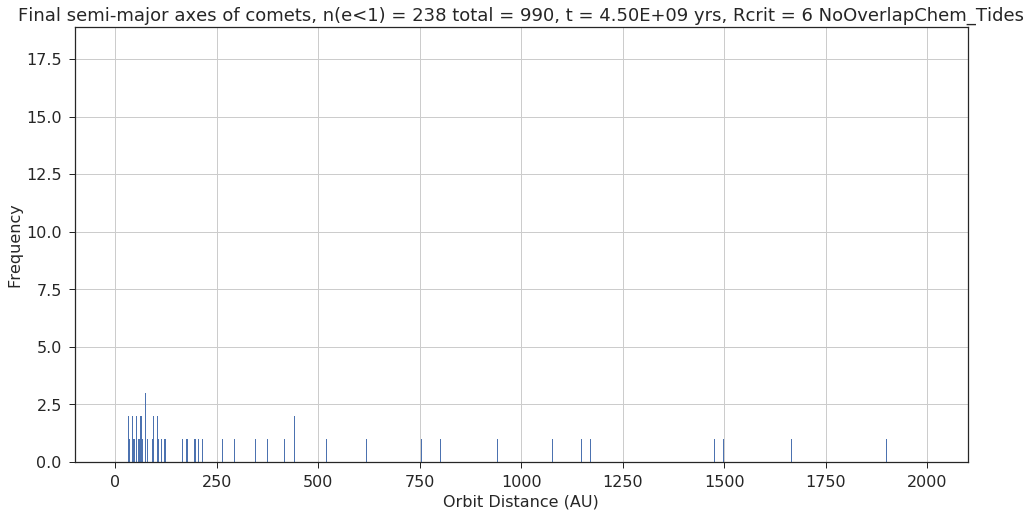

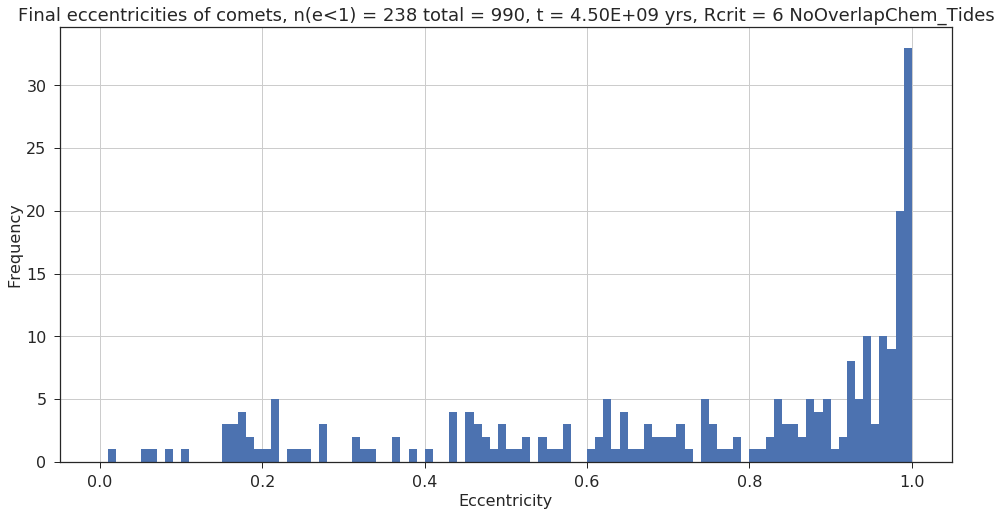

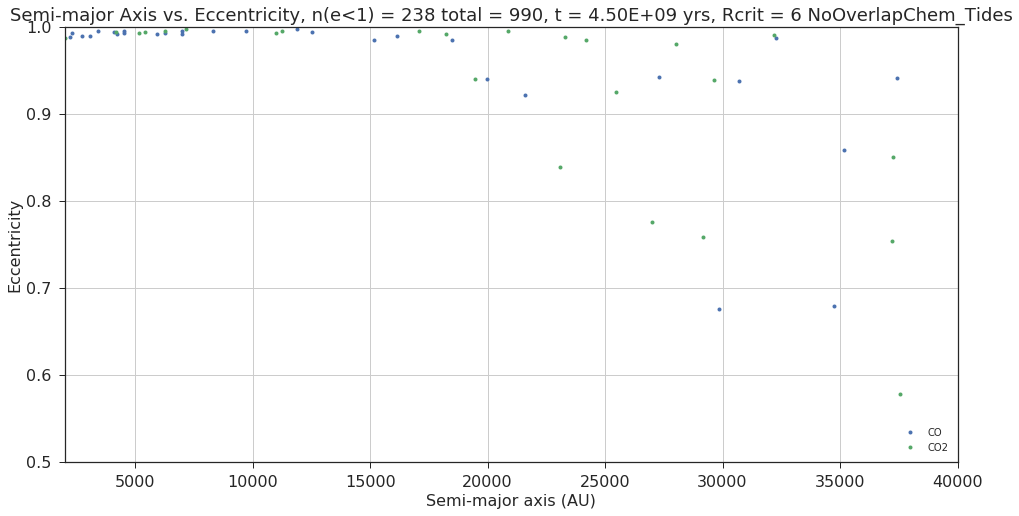

In [69]:
#Plot histograms and graph of comet semi-major axes and eccentricities (final positions)

#timescale = '%.2E' % Decimal(t_list[-1])
timescale = '%.2E' % 4.5e9

def get_hists_and_a_e(orbits_a,orbits_e,df,df2,ChemDist,sim_name_,timescale,Rcrit):
    plot_a_hist(orbits_a,sim_name_,timescale,Rcrit,ChemDist)
    plot_e_hist(orbits_e,sim_name_,timescale,Rcrit,ChemDist)
    plot_a_e(df,df2,sim_name_,timescale,Rcrit,ChemDist)

get_hists_and_a_e(list(orbits_conc["a"]),list(orbits_conc["e"]),orbits_conc,observed_orbits,ChemDist,
                      "n(e<1) = "+str((orbits_conc['e'] < 1.).sum())+" total = "+str(len(orbits_conc['e'])),str(timescale),Rcrit)

In [ ]:
#Plot orbit distances wrt time

#Pick five random comets to plot
#comet_index_shuffle = np.arange(0,len(orbits_conc["a"]))[0:5]
#np.random.shuffle(comet_index_shuffle)
#plot_a_time(orbits_conc["a"],t_list,"n ="+str(orbits_conc.shape[0]))
#plot_e_time(orbits_conc["e"],t_list,"n ="+str(orbits_conc.shape[0]))